In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from data import data_reader

Tensor = torch.Tensor
rand_m = np.random.random

In [2]:
MODEL_NAME = 'densenet121'
if not os.path.exists('weights/'):
    !mkdir weights
if not os.path.exists('weights/{}'.format(MODEL_NAME)):
    !mkdir weights/{MODEL_NAME}

In [3]:
class model_densenet(nn.Module):
    def __init__(self, num_class):
        super(model_densenet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.avgp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1000, num_class)
    
    def forward(self, x):
        x = self.densenet(x)
        #print(x.shape)
        #x = self.avgp(x)
        #print(x.shape)
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        return x

In [4]:
model = model_densenet(6).to('cuda')

/data/tennant/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [5]:
optim = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [6]:
from data import data_reader
class args:
    bs = 64
    path = 'train2000/'

dr = data_reader(args, 'train2000/train2000.csv')

train_loader, test_loader = dr.get_train_loader()

In [ ]:
train_loss_rec = []
train_acc_rec = []
test_loss_rec = []
test_acc_rec = []
best_acc = 0
for epoch in range(50):
    epoch_loss = 0
    total, correct = 0, 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        optim.zero_grad()
        y_hat = model(X_train)
        loss = loss_func(y_hat, torch.max(y_train, 1)[1])
        loss.backward()
        _, pred = torch.max(y_hat.data, 1)
        optim.step()
        correct += (pred == torch.max(y_train, 1)[1]).sum().item()
        total += X_train.size(0)
        epoch_loss += loss.item() / len(train_loader)
        print('\rEpoch {} | Batch # {} Train Loss {:.5f} '.format(epoch, batch_idx, loss.item()))
    print('\rEpoch {} | Epoch Train Loss {:.5f}'.format(epoch, epoch_loss))
    epoch_acc = correct / total * 100
    print('\nEpoch {} | Epoch Train Acc {:.3f}%'.format(epoch, epoch_acc))
    train_loss_rec.append(epoch_loss)
    train_acc_rec.append(epoch_acc)
    with torch.no_grad():
        test_epoch_loss = 0
        test_total = 0
        test_correct = 0
            
        for batch_idx, (X_val, y_val) in enumerate(test_loader):
            X_val, y_val = X_val.to('cuda'), y_val.to('cuda')
            
            y_hat = model(X_val)
            loss = loss_func(y_hat, torch.max(y_val, 1)[1])
            _, pred = torch.max(y_hat.data, 1)
            print(pred[:5])
            print(pred.shape)
            test_total += y_val.size(0)
            test_correct += (pred == torch.max(y_val, 1)[1]).sum().item()
            test_epoch_loss += loss.item() / len(test_loader)
             
        test_epoch_acc = test_correct / test_total * 100
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            torch.save(model.state_dict(), 'weights/' + MODEL_NAME + '/best_params_acc{}.pth'.format(best_acc)) 
        print('Epoch {} | Epoch Val Loss {:.5f}'.format(epoch, test_epoch_loss))
        print('Epoch {} | Epoch Val Acc {:.3f}%'.format(epoch, test_epoch_acc))
            
        test_loss_rec.append(test_epoch_loss)
        test_acc_rec.append(test_epoch_acc)

Epoch 0 | Batch # 0 Train Loss 2.35897 
Epoch 0 | Batch # 1 Train Loss 0.95653 
Epoch 0 | Batch # 2 Train Loss 0.76323 
Epoch 0 | Batch # 3 Train Loss 0.86374 
Epoch 0 | Batch # 4 Train Loss 0.45615 
Epoch 0 | Batch # 5 Train Loss 0.80202 
Epoch 0 | Batch # 6 Train Loss 1.15731 
Epoch 0 | Batch # 7 Train Loss 0.55370 
Epoch 0 | Batch # 8 Train Loss 0.35702 
Epoch 0 | Batch # 9 Train Loss 0.49387 
Epoch 0 | Batch # 10 Train Loss 0.58993 
Epoch 0 | Batch # 11 Train Loss 0.51045 
Epoch 0 | Batch # 12 Train Loss 0.62309 
Epoch 0 | Batch # 13 Train Loss 0.43054 
Epoch 0 | Batch # 14 Train Loss 0.42483 
Epoch 0 | Batch # 15 Train Loss 0.45890 
Epoch 0 | Batch # 16 Train Loss 0.45457 
Epoch 0 | Batch # 17 Train Loss 0.35107 
Epoch 0 | Batch # 18 Train Loss 0.73025 
Epoch 0 | Batch # 19 Train Loss 0.24205 
Epoch 0 | Batch # 20 Train Loss 0.41407 
Epoch 0 | Batch # 21 Train Loss 0.55252 
Epoch 0 | Batch # 22 Train Loss 0.35738 
Epoch 0 | Batch # 23 Train Loss 0.44051 
Epoch 0 | Batch # 24 Train

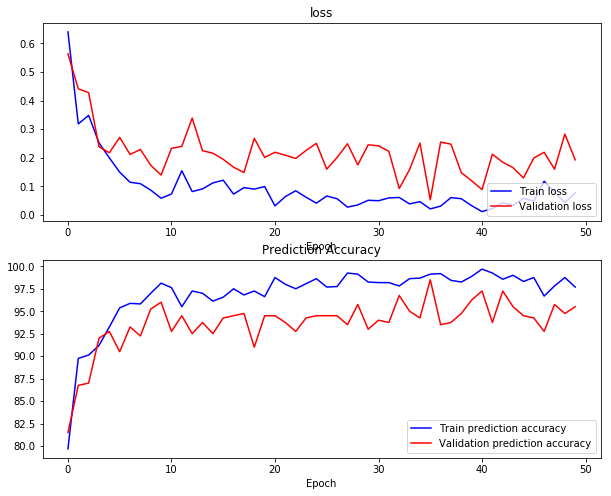

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.subplot(2,1,1)
plt.plot(train_loss_rec, 'b')
plt.plot(test_loss_rec, 'r')

plt.title('loss')
plt.xlabel('Epoch')

plt.legend(['Train loss', 'Validation loss'], loc=4)

plt.subplot(2,1,2)
plt.plot(train_acc_rec, 'b')
plt.plot(test_acc_rec, 'r')

plt.title('Prediction Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train prediction accuracy' ,'Validation prediction accuracy'], loc=4)
plt.show()